**Предварительная работа:**

**1.** Подключение гугл-диска, на котором хранятся данные.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2.** Установка модулей biopython и bedtools.

In [1]:
!pip install biopython

     |████████████████████████████████| 2.3MB 32.9MB/s 


In [2]:
!apt-get install bedtools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 577 kB of archives.
After this operation, 2,040 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 bedtools amd64 2.26.0+dfsg-5 [577 kB]
Fetched 577 kB in 1s (992 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../bedtools_2.26.0+dfsg-5_amd64.deb ...
Unpacking bedtools (2.26.0+dfsg-5) ...
Setting up bedtools (2.26.0+dfsg-5) ...


In [3]:
!pip install pybedtools

     |████████████████████████████████| 12.5MB 221kB/s 
     |████████████████████████████████| 9.9MB 41.0MB/s 
  Created wheel for pybedtools: filename=pybedtools-0.8.2-cp37-cp37m-linux_x86_64.whl size=13616962 sha256=df2b707bbfaf792a08cc33a628ac7b899d78a57aacd27ee5f4a80f83d96f51c4
  Stored in directory: /root/.cache/pip/wheels/ab/ae/8d/efdbbacea1f52e55602720575328b97fed787bd12723d25d5b
Successfully built pybedtools


**3.** Прочтение файла с сайтами формирования триплексов.

In [4]:
filename = '/content/drive/My Drive/bioinf/GSM3417036_TriplexDNASeq_plus_RNA_ligation.bed'

In [5]:
from pybedtools import BedTool

In [6]:
data = BedTool(filename)

In [7]:
example = data[0]

In [8]:
example.chrom

'chr1'

In [9]:
example.start

629800

In [10]:
example.end

630250

In [11]:
example.strand

'-'

**4.** Прочтение файлов с последовательностью ДНК человеческого генома.

In [12]:
names = ['chr' + str(i + 1) for i in range(22)]
names.append('chrX')
names.append('chrY')
names

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr20',
 'chr21',
 'chr22',
 'chrX',
 'chrY']

In [13]:
from Bio import SeqIO

chroms = {}

for name in names:
  chroms[name] = SeqIO.read('/content/drive/My Drive/bioinf/hg38/' + name + '.fa', 'fasta')

In [14]:
chroms[example.chrom][example.start:example.end]

SeqRecord(seq=Seq('AGCTGCCATCAAGTATTTCCTCACGCAAGCAACCGCATCCATAATCCTTCTAAT...TAA'), id='chr1', name='chr1', description='chr1', dbxrefs=[])

**5.** Получение последовательности ДНК на заданном участке генома и перевод её в признаки для модели при помощи one-hot encoding.

In [15]:
import math

input_len = 2000

In [16]:
def get_subseq(record, subseq_len=input_len):
    left_add = 0
    right_add = 0
    if abs(record.end - record.start) > subseq_len:
        output = []
        start = record.start - (subseq_len // 2 * math.ceil((record.end - record.start) / (subseq_len // 2)) - (record.end - record.start)) // 2
        end = start + subseq_len
        while start <= record.end:
            if record.strand == '-':
                output.append(chroms[record.chrom][start:end].seq.reverse_complement())
            else:
                output.append(chroms[record.chrom][start:end].seq)
                
            start += subseq_len // 2
            end += subseq_len // 2
        return output
            
                

    left_add = (subseq_len - abs(record.end - record.start)) // 2
    right_add = subseq_len - abs(record.end - record.start) - left_add
    if record.strand == '-':
        chrom_len = len(chroms[record.chrom])
        return [chroms[record.chrom][record.start - left_add:record.end + right_add].seq.reverse_complement()]
    return [chroms[record.chrom][record.start - left_add:record.end + right_add].seq]


In [17]:
len(get_subseq(example)[0])

2000

In [18]:
import numpy as np
from Bio import Seq

In [19]:
def seq_to_onehot(sequence):
  onehot = np.zeros((len(sequence), 4))
  for i, nucleotide in enumerate(sequence):
    if nucleotide.lower() == 'a':
      onehot[i][0] = 1
    if nucleotide.lower() == 't':
      onehot[i][1] = 1
    if nucleotide.lower() == 'g':
      onehot[i][2] = 1
    if nucleotide.lower() == 'c':
      onehot[i][3] = 1
  return onehot

**6.** Формирование выборки данных из сайтов формирования триплексных ДНК и случайных участков генома.

In [20]:
seq_data = []
used_positions = {}

for name in names:
    used_positions[name] = set()

for record in data:
    if chroms[record.chrom][record.start:record.end].seq.count('N') / input_len < 0.01:
        seq_data.extend([seq_to_onehot(x) for x in get_subseq(record)])
        used_positions[record.chrom].update(set(range(record.start, record.end)))

seq_data[0]

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [21]:
from random import choice, randrange

num_of_random_seqs = len(seq_data)

random_seqs = []
while(len(random_seqs) < num_of_random_seqs):
    chrom = choice(names)
    start = randrange(len(chroms[chrom]) - input_len)
    end = start + input_len
    strand = choice([0, 1])
    if chroms[chrom][start:end].seq.count('N') / input_len < 0.01 and used_positions[chrom].isdisjoint(set(range(start, end))):
        used_positions[chrom].update(set(range(start, end)))
        if strand == 1:
            random_seqs.append(seq_to_onehot(chroms[chrom][start:end].seq.reverse_complement()))
        else:
            random_seqs.append(seq_to_onehot(chroms[chrom][start:end].seq))


In [22]:
random_seqs[0]

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [23]:
random_seqs[0].shape

(2000, 4)

In [24]:
from random import shuffle

X = seq_data.copy()
X.extend(random_seqs)

In [25]:
y = [1 for i in range(len(seq_data))]
print(len(y))
y.extend([0 for i in range(len(random_seqs))])
print(len(y))

2613
5226


In [26]:
X = np.stack(X, axis=0)



In [27]:
y = np.array(y)

In [28]:
X.shape

(5226, 2000, 4)

In [29]:
y.shape

(5226,)

**7.** Разбитие на обучающую и тестовую выборку для предварительного запуска модели.

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [54]:
X_train.shape

(4180, 2000, 4)

In [55]:
y_train.shape

(4180,)

In [56]:
y_test[:10]

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1])

In [34]:
del chroms

**Обучение и интерпретация свёрточных нейронных сетей:**

**1.** Обучение одного из вариантов свёрточных нейронных сетей.

In [50]:
def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    if curr_session is not None:
        curr_session.close()
    tf.keras.backend.clear_session()
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
    tf.compat.v1.keras.backend.set_session(s)
    return s

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, LeakyReLU, Conv1D, GlobalMaxPool1D, MaxPooling1D
import tensorflow as tf

def make_model_CNN():
    model = Sequential()
    model.add(Conv1D(filters=40, kernel_size=25, input_shape=(input_len, 4)))
    model.add(LeakyReLU())
    model.add(MaxPooling1D(pool_size=20, strides=7))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=40, kernel_size=25))
    model.add(LeakyReLU())
    model.add(MaxPooling1D(pool_size=20, strides=7))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=40, kernel_size=25))
    model.add(LeakyReLU())
    model.add(GlobalMaxPool1D())
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    
    return model

In [58]:
model = make_model_CNN()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
s = reset_tf_session()
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 15

bst_model_path = 'CNN' + '.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch
  
model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0
  )


Epoch 1/15
131/131 [==============================] - 3s 13ms/step - loss: 1.1849 - accuracy: 0.5458 - precision: 0.5507 - recall: 0.4917 - auc: 0.5733 - val_loss: 0.6161 - val_accuracy: 0.6941 - val_precision: 0.6556 - val_recall: 0.8718 - val_auc: 0.7409
Epoch 2/15
131/131 [==============================] - 1s 9ms/step - loss: 0.6075 - accuracy: 0.6735 - precision: 0.6624 - recall: 0.7029 - auc: 0.7351 - val_loss: 0.6429 - val_accuracy: 0.6033 - val_precision: 0.7695 - val_recall: 0.3425 - val_auc: 0.7502
Epoch 3/15
131/131 [==============================] - 1s 9ms/step - loss: 0.5929 - accuracy: 0.6989 - precision: 0.6924 - recall: 0.7244 - auc: 0.7543 - val_loss: 0.6616 - val_accuracy: 0.6233 - val_precision: 0.7533 - val_recall: 0.4139 - val_auc: 0.7556
Epoch 4/15
131/131 [==============================] - 1s 8ms/step - loss: 0.5786 - accuracy: 0.7078 - precision: 0.7185 - recall: 0.7050 - auc: 0.7700 - val_loss: 0.6283 - val_accuracy: 0.6377 - val_precision: 0.7554 - val_recall: 

**2.** Проверка устойчивости результата при помощи KFold.

In [ ]:
kfold_testing(X, y, make_model_CNN, 'CNN')

**3.** Получение мотивов из весов фильтров первого слоя модели.

In [59]:
drive_path = '/content/drive/My Drive/'

bst_weights_pth = drive_path + 'bioinf/CNN.h5'

model.load_weights('CNN.h5')

In [60]:
counter = 1

for j in range(model.layers[0].weights[0].numpy().shape[2]):
    filter = model.layers[0].weights[0].numpy()[:,:,j]
    sum = 0

    print('Filter ' + str(counter))
    counter += 1
    for i in range(len(filter)):
        maximum = np.max(filter[i, :])
        
        #print(filter[0][i])
        if maximum <= 0.05:
            print('-', end='')
        elif filter[i][0] == maximum:
            print('A', end='')
        elif filter[i][1] == maximum:
            print('T', end='')
        elif filter[i][2] == maximum:
            print('G', end='')
        elif filter[i][3] == maximum:
            print('C', end='')
        if maximum >= 0.05:
            sum += maximum
    print()
    print(sum)
    print()

Filter 1
G-CAT---C-CCGT-C-T-G----C
0.8794426545500755

Filter 2
-G-CTTAA--T--TC-C-G--A--A
0.8991922996938229

Filter 3
C-CT---T----CGG-G----GC-G
0.7949188649654388

Filter 4
CT-T--A-C-T---C-TA---AT--
0.8383621387183666

Filter 5
G-CA-AGA-TC----T--C-T---C
0.795154545456171

Filter 6
-C-TAT-TA-AT-CT-A-TATC--T
1.1460862830281258

Filter 7
---G--TC-A--CGA-TCGA-T-GA
1.2684755809605122

Filter 8
-TG--CG--TC--A--TA---A---
0.6205623708665371

Filter 9
-----GTA------A---AA--TTA
0.6050139665603638

Filter 10
---TCAA-CT-----TAG-------
0.7268086299300194

Filter 11
--G-AAAC--A-AT--CTG--CGTC
1.1540953144431114

Filter 12
-A---TGCT------A-GC-G-C--
0.5981429368257523

Filter 13
-GA---C---ATA---T-TC-CC-G
0.7757544815540314

Filter 14
------A--G-ATATA--G----A-
0.5960096009075642

Filter 15
G--CC-AT-CGGG-G--TCA--G--
0.8831029571592808

Filter 16
G-GT---T-----AGA---T-C--C
0.638378344476223

Filter 17
A-AT-A-A--TAG-A-T-T-CAT-C
1.023753710091114

Filter 18
A-AT----G-G-C--T----A---A
0.6190157160162926

Filt

**4.** Графическое представление весов фильтров первого слоя модели.

In [61]:
!pip install seaborn

In [62]:
max_abs = np.max(np.abs(model.layers[0].weights[0].numpy()))

In [63]:
model.layers[0].weights[0].numpy().shape

(25, 4, 40)

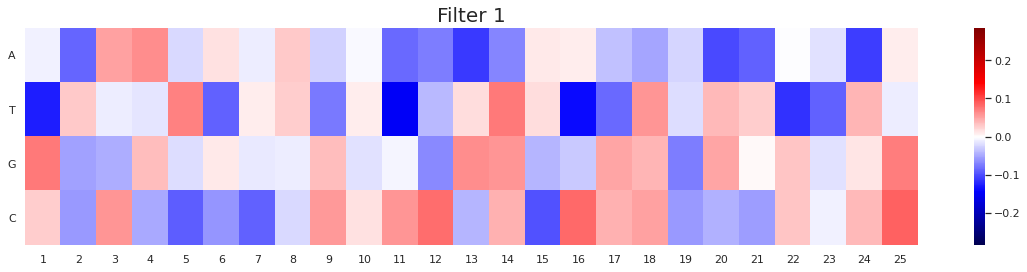

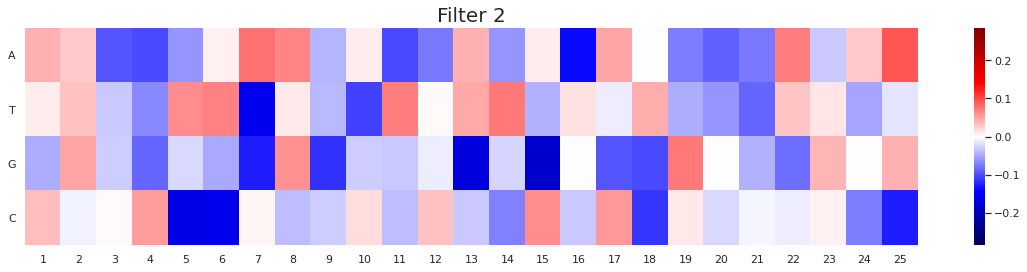

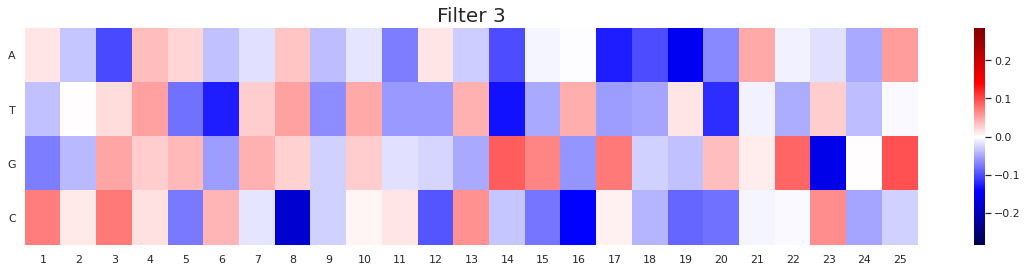

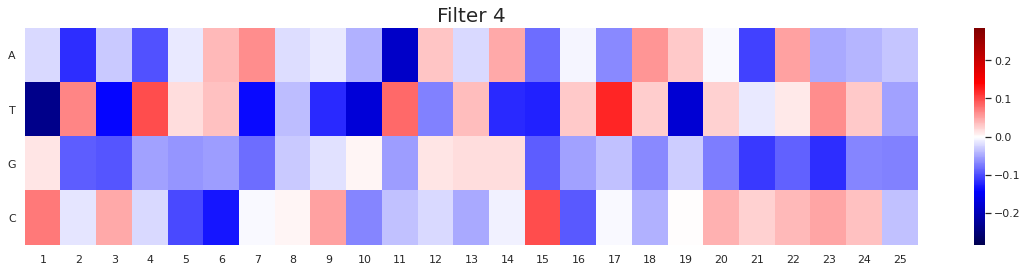

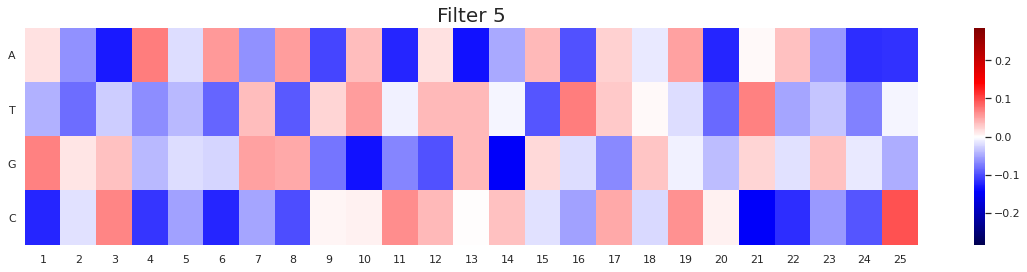

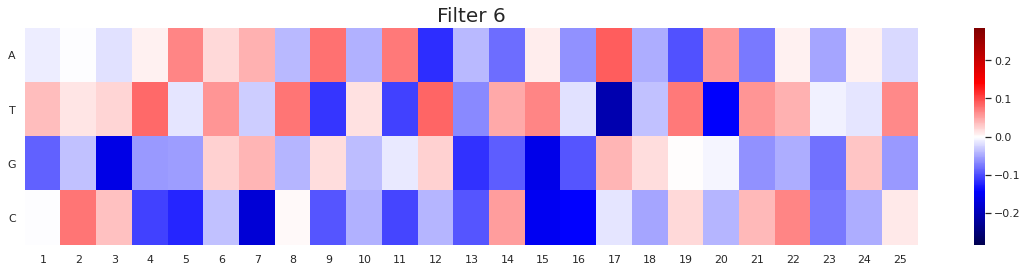

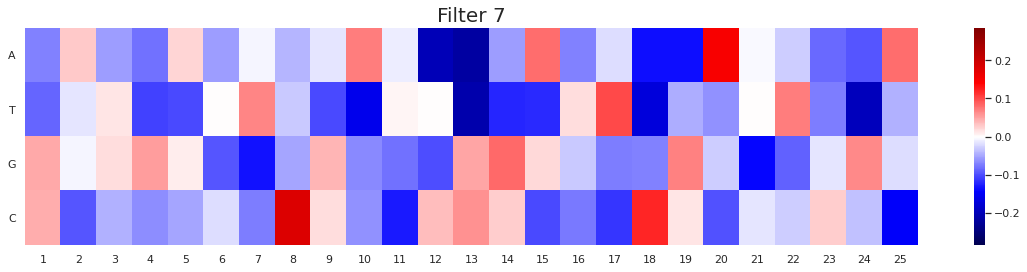

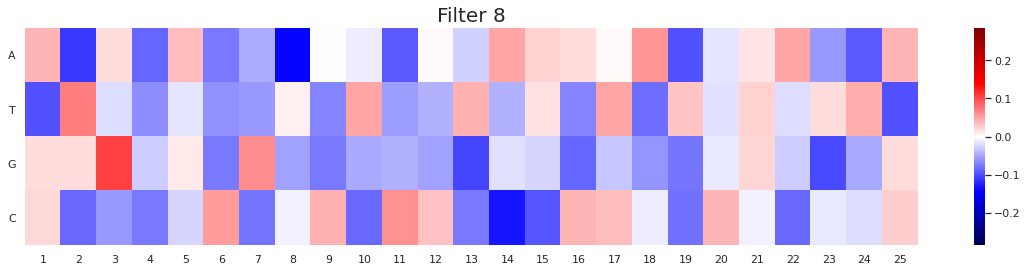

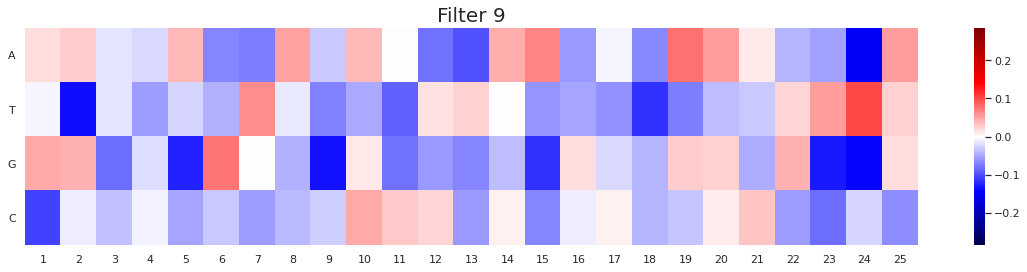

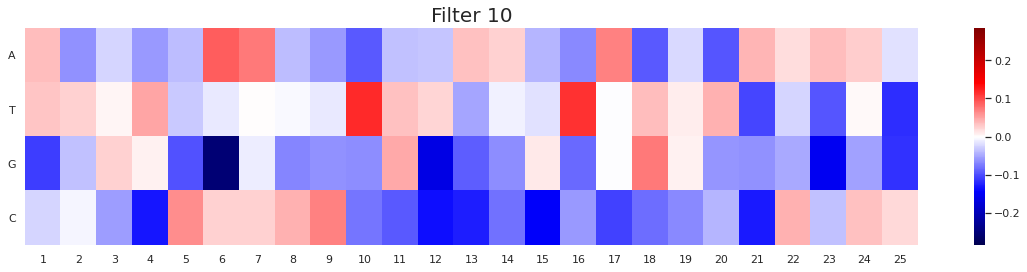

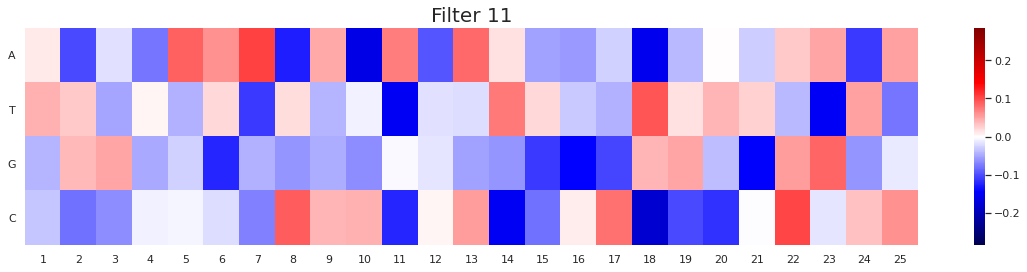

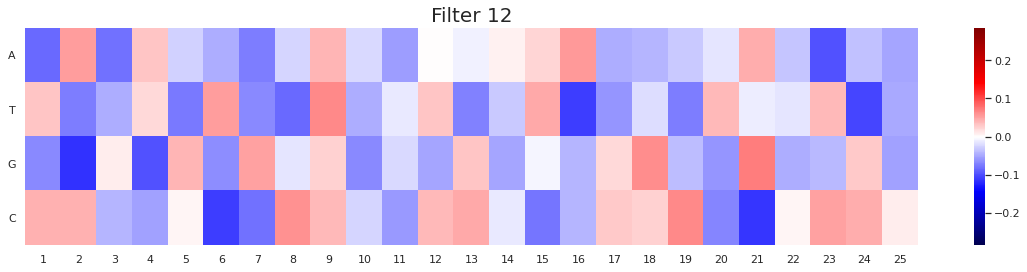

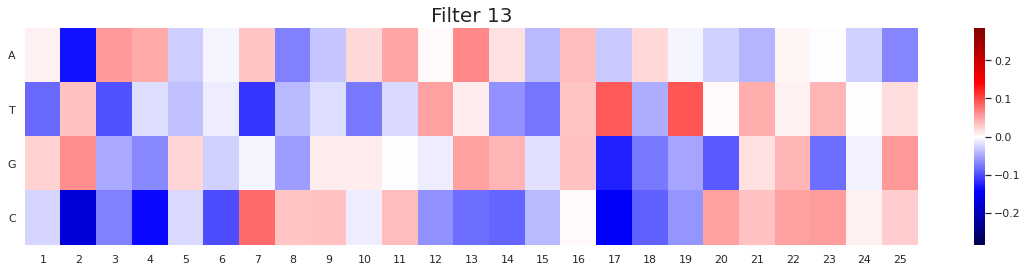

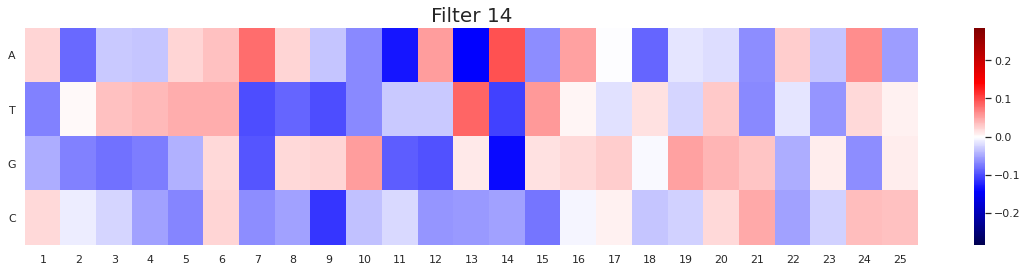

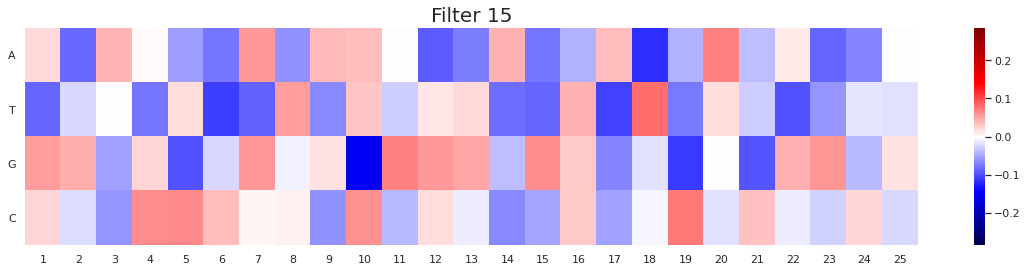

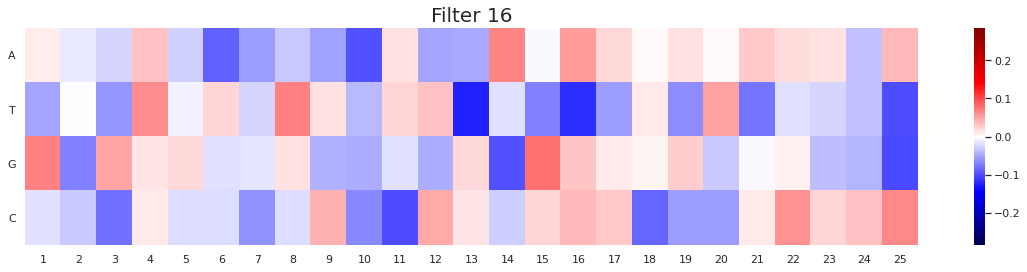

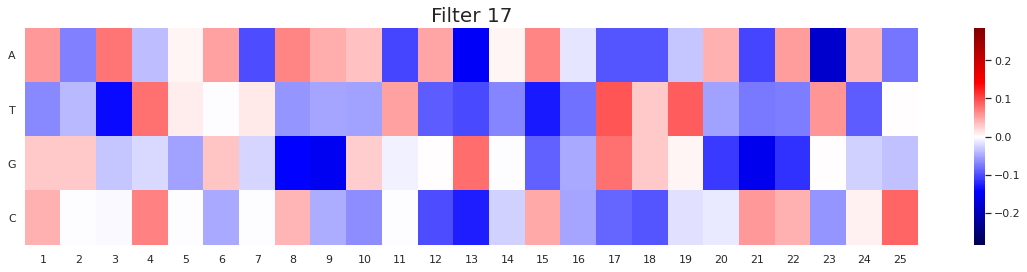

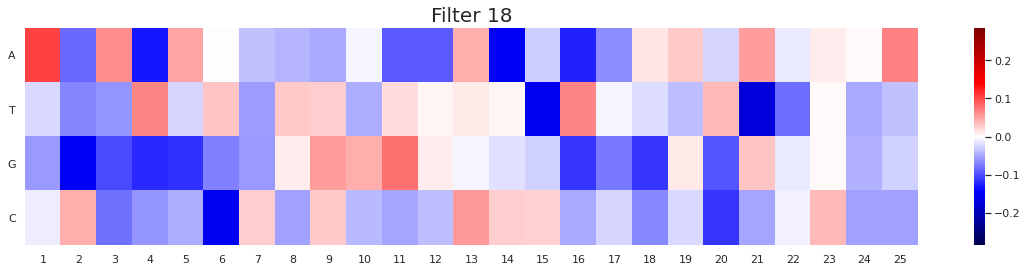

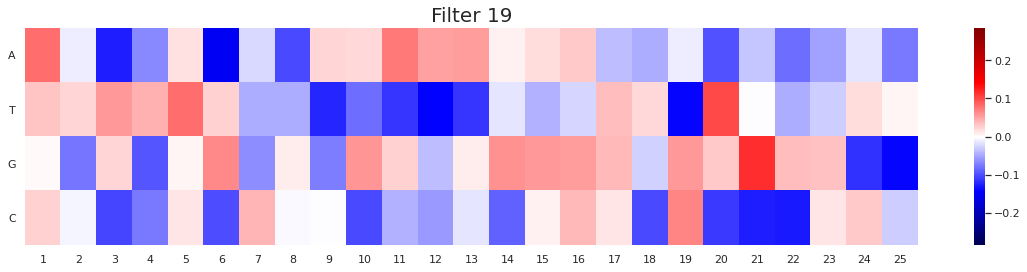

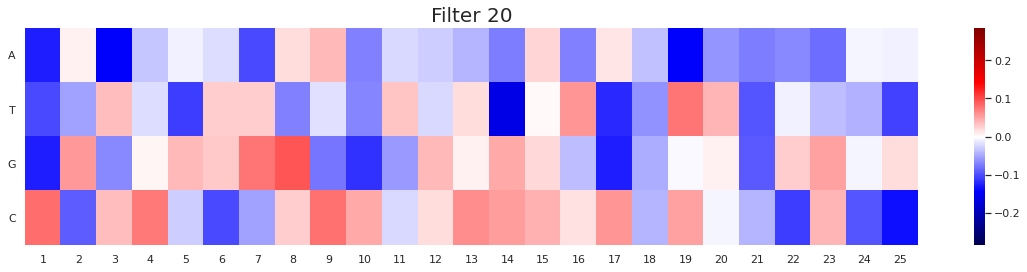

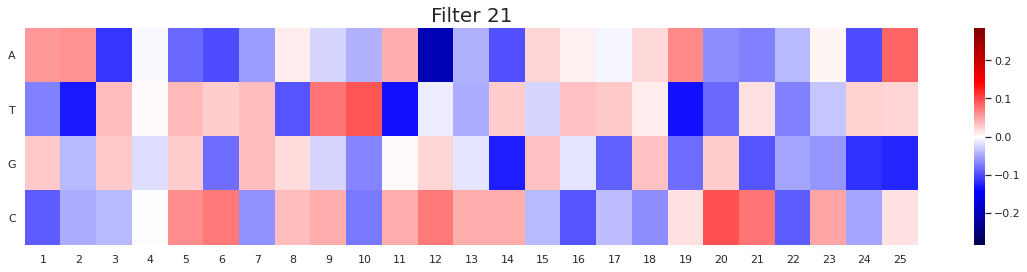

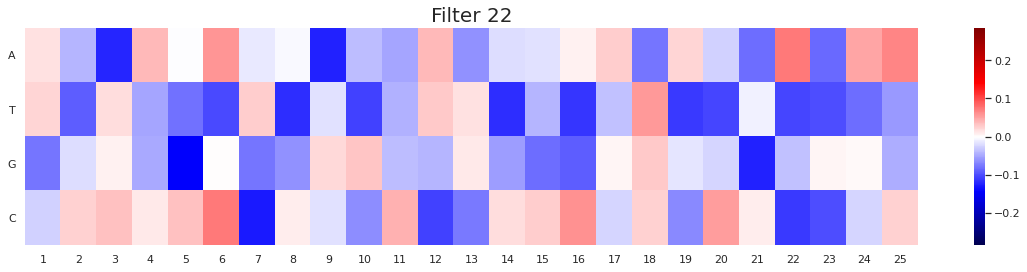

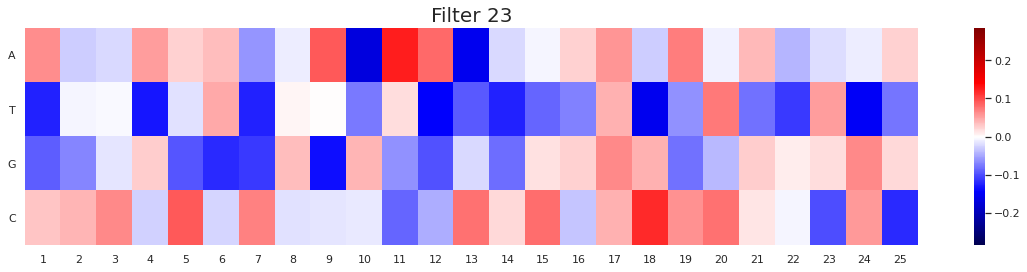

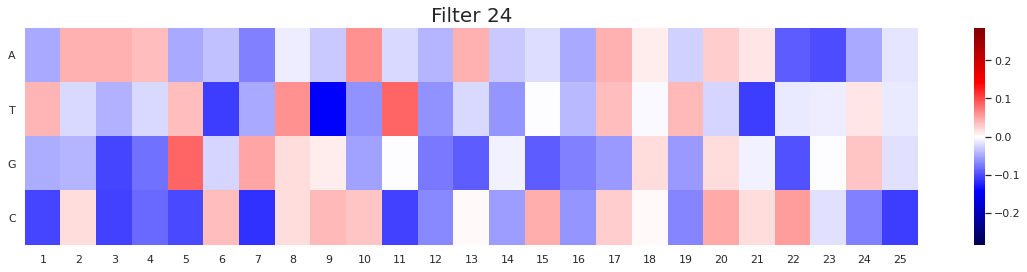

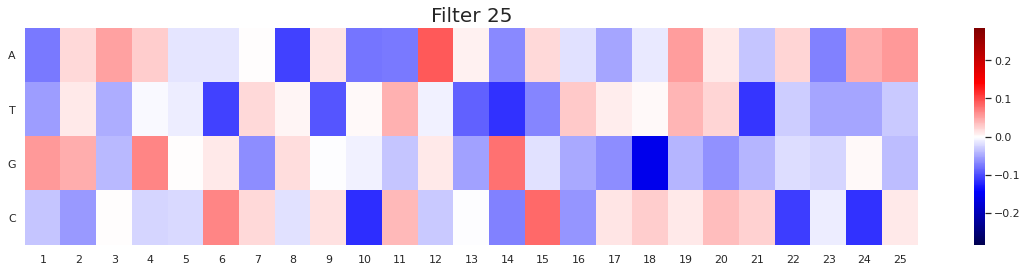

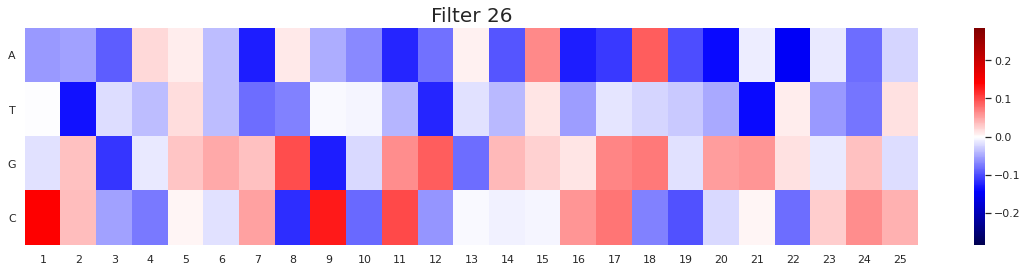

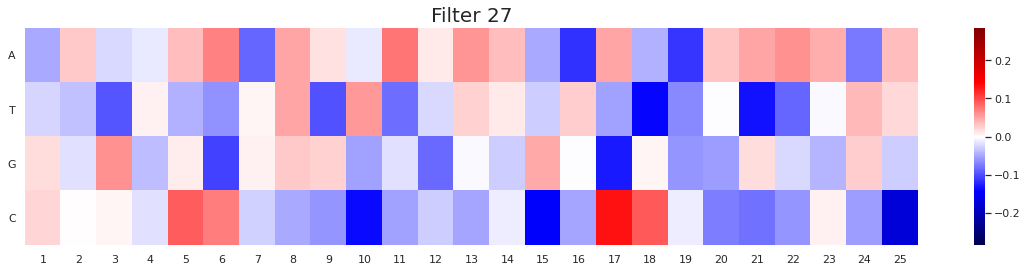

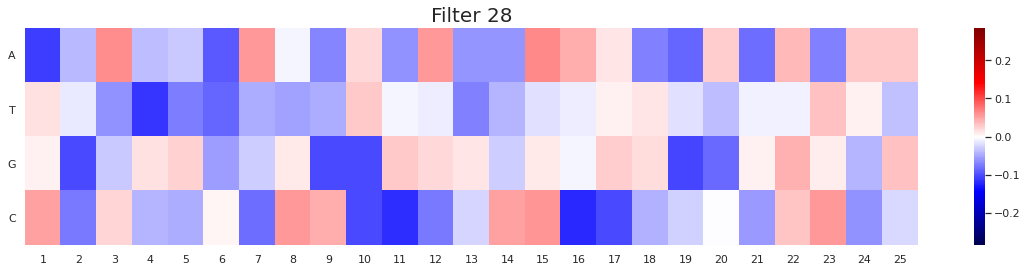

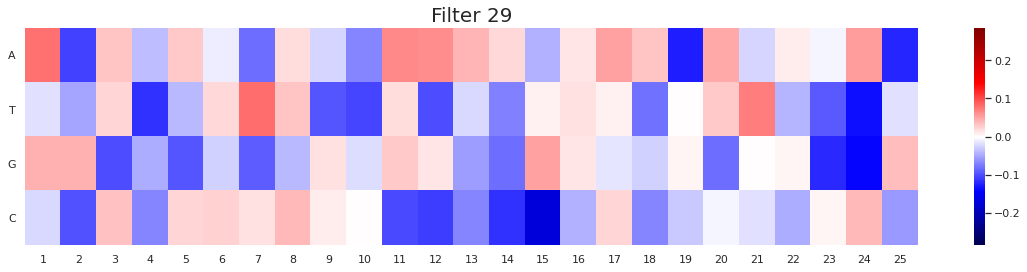

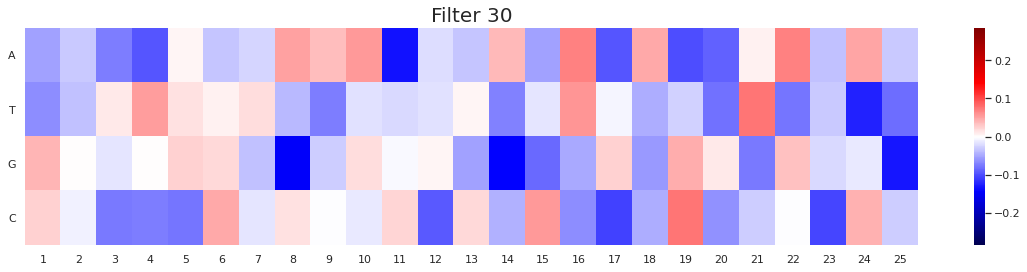

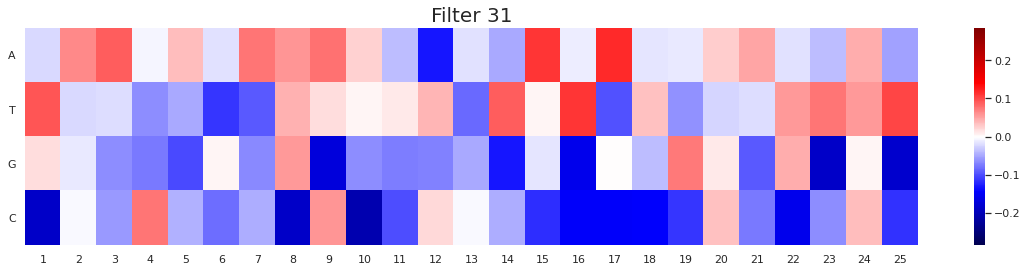

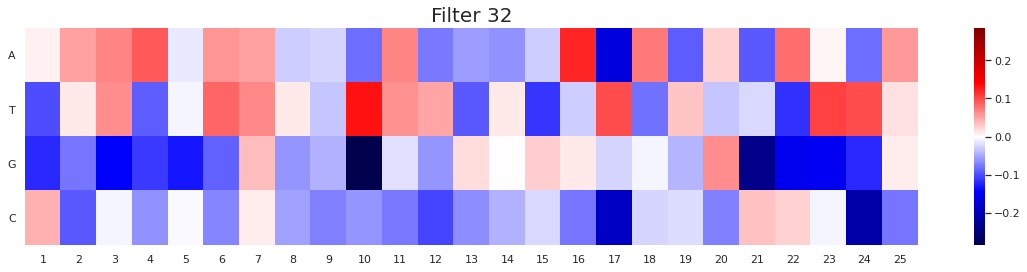

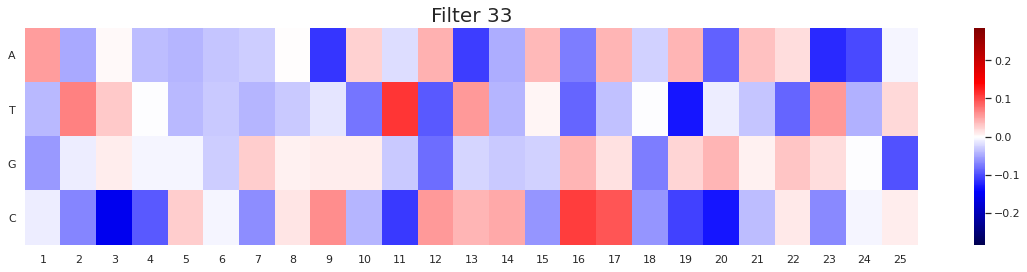

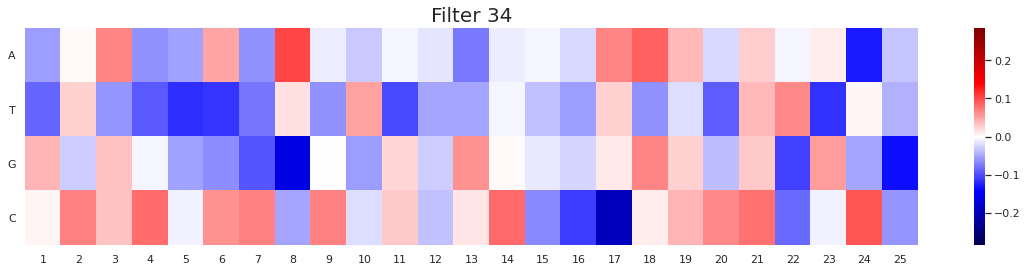

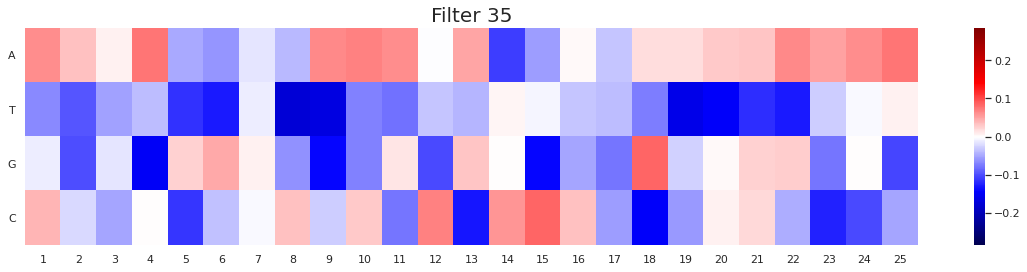

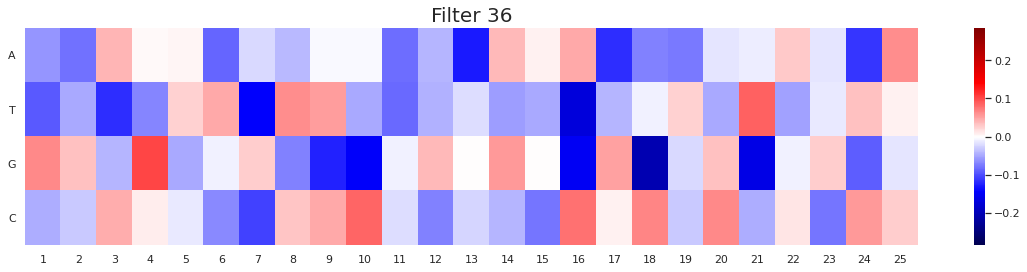

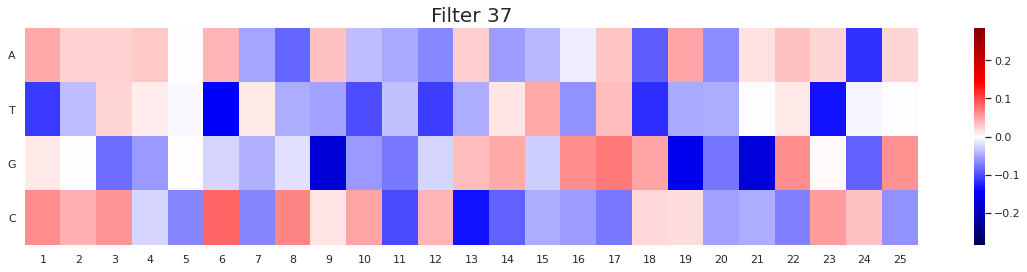

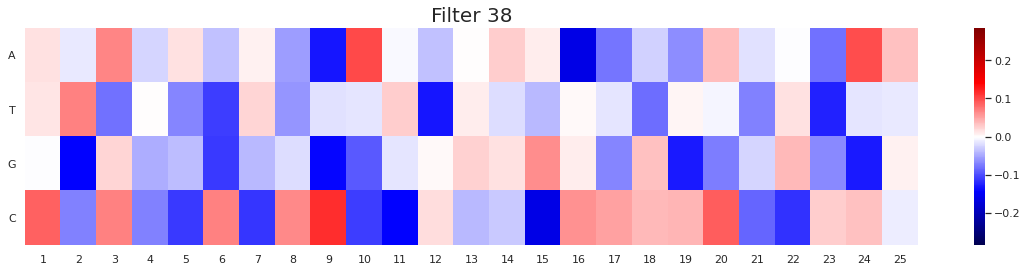

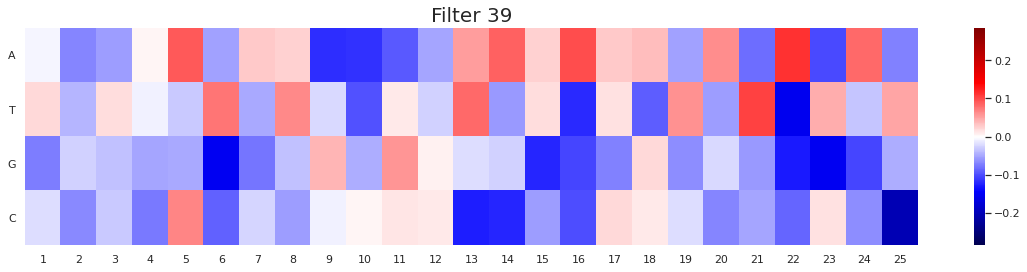

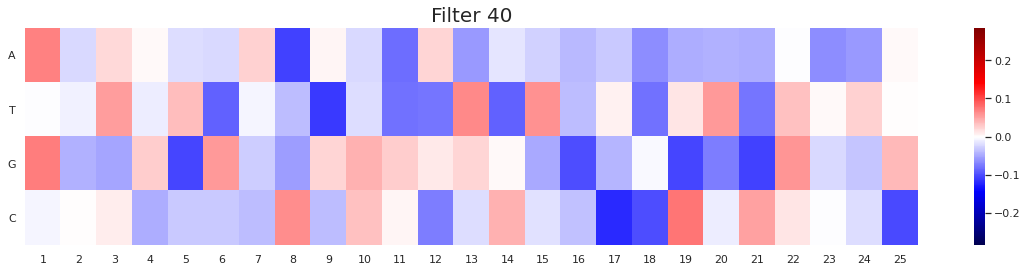

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


counter = 1
for j in range(model.layers[0].weights[0].numpy().shape[2]):
    filter = model.layers[0].weights[0].numpy()[:,:,j]
    plt.figure(figsize=(20, 4))
    ax = sns.heatmap(np.transpose(filter), vmin=-max_abs, vmax=max_abs, center=0, cmap='seismic')
    ax.set_yticklabels(['A', 'T', 'G', 'C'], rotation=0)
    ax.set_xticklabels(np.array(range(len(filter))) + 1, rotation=0)
    ax.set_title('Filter ' + str(counter), fontsize=20)
    plt.show()
    counter += 1

**5.** Сравнение свёрточных сетей с различными параметрами.

In [ ]:
from sklearn.model_selection import KFold

def kfold_testing(X, y, make_model, name):
    
    n_folds = 5
    accuracy = 0
    auc = 0
    loss = 0
    metrics = np.zeros((5))

    kfolds = KFold(n_splits=n_folds, shuffle=True)

    for train, test in kfolds.split(X, y):
        
        model = make_model()

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        s = reset_tf_session()
        INIT_LR = 5e-3
        BATCH_SIZE = 32
        EPOCHS = 30

        bst_model_path = name + '.h5'
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

        model.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )

        def lr_scheduler(epoch):
            return INIT_LR * 0.9 ** epoch
    
        model.fit(
            X[train], y[train],
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
            validation_data=(X[test], y[test]),
            shuffle=True,
            verbose=0,
            initial_epoch=0
        )

        model.load_weights(bst_model_path)
        metrics += np.array(model.evaluate(X[test], y[test], verbose=1))
    return np.array(metrics) / n_folds

In [ ]:
convolution_params = [(40, 30), (40, 25), (40, 20), (40, 15), (30, 25), (30, 20), (30, 15), (25, 20), (25, 15), (20, 15)]
pooling_params = [(20, 7), (15, 7)]
dropout_params = [(0.2, 0.1)]

min_loss = 100000
best = []
best_params = []

for conv_filters, conv_size in convolution_params:
    for pool_size, pool_stride in pooling_params:
        local_best = []
        local_min = 100000
        local_params = []
        for dropout1, dropout2 in dropout_params:
            def make_model_CNN():
                model = Sequential()
                model.add(Conv1D(filters=conv_filters, kernel_size=conv_size, input_shape=(input_len, 4)))
                model.add(LeakyReLU())
                model.add(MaxPooling1D(pool_size=pool_size, strides=pool_stride))
                model.add(Dropout(dropout1))
                model.add(Conv1D(filters=conv_filters, kernel_size=conv_size))
                model.add(LeakyReLU())
                model.add(MaxPooling1D(pool_size=pool_size, strides=pool_stride))
                model.add(Dropout(dropout2))
                model.add(Conv1D(filters=conv_filters, kernel_size=conv_size))
                model.add(LeakyReLU())
                model.add(GlobalMaxPool1D())
                model.add(Dense(1))
                model.add(Activation("sigmoid"))
                
                return model

            print('# of convolution filters: ' + str(conv_filters))
            print('convolution size: ' + str(conv_size))
            print('pool size: ' + str(pool_size))
            print('pool stride: ' + str(pool_stride))
            print('first dropout: ' + str(dropout1))
            print('second dropout: ' + str(dropout2))
            res = kfold_testing(X, y, make_model_CNN, 'CNN')
            print(res)
            if res[0] < min_loss:
                min_loss = res[0]
                best = res
                best_params = [(conv_filters, conv_size), (pool_size, pool_stride), (dropout1, dropout2)]
            if res[0] < local_min:
                local_min = res[0]
                local_best = res
                local_params = [(conv_filters, conv_size), (pool_size, pool_stride), (dropout1, dropout2)]
        #print('Local best try:')
        #print(local_best)
        #print(local_params)

print('Best try:')
print(best)
print(best_params)


# of convolution filters: 40
convolution size: 30
pool size: 20
pool stride: 7
first dropout: 0.2
second dropout: 0.1
33/33 [==============================] - 0s 5ms/step - loss: 0.5734 - accuracy: 0.6900 - precision: 0.7311 - recall: 0.5828 - auc: 0.7842
[0.56267246 0.70646802 0.70596206 0.71121817 0.78416545]
# of convolution filters: 40
convolution size: 30
pool size: 15
pool stride: 7
first dropout: 0.2
second dropout: 0.1
33/33 [==============================] - 0s 5ms/step - loss: 0.5630 - accuracy: 0.7120 - precision: 0.7043 - recall: 0.7220 - auc: 0.7805
[0.56517822 0.71431034 0.70334793 0.74396061 0.78194444]
# of convolution filters: 40
convolution size: 25
pool size: 20
pool stride: 7
first dropout: 0.2
second dropout: 0.1
33/33 [==============================] - 0s 5ms/step - loss: 0.5650 - accuracy: 0.7177 - precision: 0.7122 - recall: 0.7352 - auc: 0.7836
[0.55740126 0.72139679 0.71286408 0.74082572 0.78835307]
# of convolution filters: 40
convolution size: 25
pool size: 

**Обучение реккурентных нейронных сетей:**

**1.** Пример обучения реккурентной модели.

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
import tensorflow as tf

for param in [15, 20, 25, 30]:

    def make_model_LSTM():
        model = Sequential()
        model.add(Bidirectional(LSTM(param, input_shape=(input_len, 4))))
        model.add(Dense(1))
        model.add(Activation("sigmoid"))

        return model
    
    print('# of units: ' + str(param))
    model = make_model_LSTM()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    s = reset_tf_session()
    INIT_LR = 5e-3
    BATCH_SIZE = 32
    EPOCHS = 30

    bst_model_path = 'LSTM' + '.h5'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    def lr_scheduler(epoch):
        return INIT_LR * 0.9 ** epoch
    
    model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
        validation_data=(X_test, y_test),
        shuffle=True,
        verbose=0,
        initial_epoch=0
    )

    model.load_weights(bst_model_path)
    metrics = model.evaluate(X_test, y_test, verbose=1)
    print(metrics)

        

# of units: 15
33/33 [==============================] - 2s 70ms/step - loss: 0.6648 - accuracy: 0.5927 - auc: 0.6343
[0.6647933721542358, 0.5927342176437378, 0.6343321800231934]
# of units: 20
33/33 [==============================] - 2s 59ms/step - loss: 0.6728 - accuracy: 0.5688 - auc: 0.6109
[0.6728463172912598, 0.5688336491584778, 0.6108672022819519]
# of units: 25
33/33 [==============================] - 2s 64ms/step - loss: 0.6692 - accuracy: 0.5822 - auc: 0.6219
[0.6691718101501465, 0.5822179913520813, 0.6218709945678711]
# of units: 30
33/33 [==============================] - 2s 70ms/step - loss: 0.6708 - accuracy: 0.5851 - auc: 0.6148
[0.6707924604415894, 0.5850860476493835, 0.6147633790969849]
